### DM-33911: Test the performance of refactored image differencing

# Test the refactored code on the 2021 diffim sprint dataset. Several runs are involved:

old imageDifferencing with best third seeing templates as baseline

new diffim with compatibility enforced

new diffim with best third seeing templates, convolve template mode

new diffim with middle third seeing templates, convolve science

new diffim with best third seeing templates, auto mode

new diffim with middle third seeing templates, auto mode


In [1]:
import sys
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
afwDisplay.setDefaultBackend('matplotlib') 
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask
task = ScaleZeroPointTask()

from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.coordinates import Angle, Latitude, Longitude
from astropy import units as u

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+ac198e9f13/config/.dustmapsrc


In [2]:
# Usual imports
sys.path.append('/project/kherner/DM-33911_diffim_refactor/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [3]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [4]:
old_diffim = SimpleNamespace(collection = 'u/kherner/DM-33911/oldDiffim_20220716',
                             apdb = 'lsstdevapdb1',
                             schema = 'kherner_dm_33911_olddiffim_20220716',
                             templName='Diff_warpedExp')

#new_forceCompat = SimpleNamespace(collection = 'u/kherner/DM-33911/forceCompatibility_with_DM-35175',
#                                  apdb = 'lsstdevapdb1',
#                                  schema = 'kherner_dm_33911_forcecompatibility_with_dm_35175',
#                                  templName='Diff_templateExp')

new_forceCompat = SimpleNamespace(collection = 'u/kherner/DM-33911/forceCompatibility_20220716',
                                  apdb = 'lsstdevapdb1',
                                  schema = 'kherner_dm_33911_forcecompatibility_20220716',
                                  templName='Diff_templateExp')

#new_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_bestThirdSeeing_with_DM-35175',
#                                       apdb = 'lsstdevapdb1',
#                                       schema = 'kherner_dm_33911_newdiffim_convolvetemplate_with_dm_35175',
#                                       templName='Diff_templateExp')

new_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_bestThirdSeeing_20220716',
                                       apdb = 'lsstdevapdb1',
                                       schema='kherner_dm_33911_newdiffim_convolvetemplate_20220716',
                                      templName='Diff_templateExp')

#new_convolveScience = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_midThirdSeeing_with_DM-35175',
#                                      apdb = 'lsstdevapdb1',
#                                      schema = 'kherner_dm_33911_newdiffim_convolvescience_with_dm_35175',
#                                      templName='Diff_templateExp')
new_convolveScience = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_midThirdSeeing_20220716',
                                      apdb = 'lsstdevapdb1',
                                      schema = 'kherner_dm_33911_newdiffim_convolvescience_20220716',
                                      templName='Diff_templateExp')

new_best_auto = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_bestThirdSeeing_autoMode',
                                      apdb = 'lsstdevapdb1',
                                      schema = 'kherner_dm_33911_newdiffim_bestthirdseeing_automode',
                                      templName='Diff_templateExp')
new_mid_auto = SimpleNamespace(collection = 'u/kherner/DM-33911/newDiffim_midThirdSeeing_autoMode',
                                      apdb = 'lsstdevapdb1',
                                      schema = 'kherner_dm_33911_newdiffim_midthirdseeing_automode',
                                      templName='Diff_templateExp')

In [5]:
apdbs_nonempty = [old_diffim, new_forceCompat, new_convolveTemplate,
                  new_convolveScience, new_best_auto, new_mid_auto ]

badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [6]:
print(f'N DiaSources and N "good" DiaSources in each collection')
print(f'-------------------------------------------------------')
for run in apdbs_nonempty:
    collection = run.collection
    apdb = run.apdb
    schema = run.schema
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=apdb,
                                                          gen='gen3',
                                                          schema=schema,
                                                          instrument='HSC',
                                                          badFlagList=badFlagList)
    print(f'{len(srcTable):7d}\t{len(goodSrc):7d}\t\t{collection.split("/")[-1]}')

N DiaSources and N "good" DiaSources in each collection
-------------------------------------------------------


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  61645	  13699		oldDiffim_20220716


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  63248	  13732		forceCompatibility_20220716


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  50239	  10664		newDiffim_bestThirdSeeing_20220716


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  57010	  26807		newDiffim_midThirdSeeing_20220716


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  48730	  11961		newDiffim_bestThirdSeeing_autoMode


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


  57492	  24764		newDiffim_midThirdSeeing_autoMode


In [7]:
oneVisit = 1220
oneDetector = 66
selname = 'goodSeeing'

diffim variance median
----------------------
436.892029	oldDiffim_20220716
437.073395	forceCompatibility_20220716
714.372437	newDiffim_bestThirdSeeing_20220716
730.068359	newDiffim_midThirdSeeing_20220716
714.372437	newDiffim_bestThirdSeeing_autoMode
730.068359	newDiffim_midThirdSeeing_autoMode


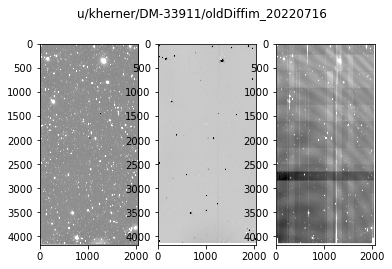

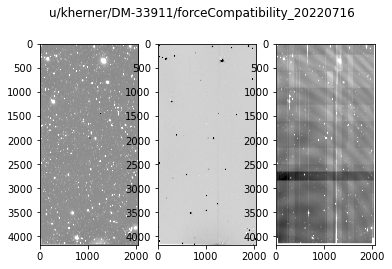

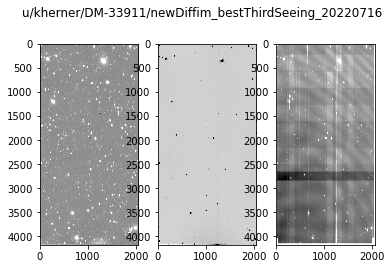

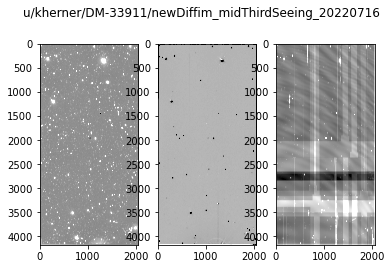

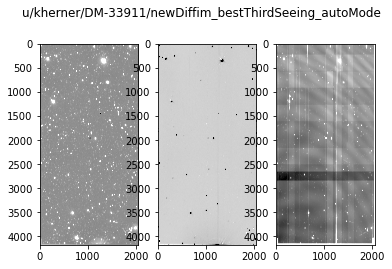

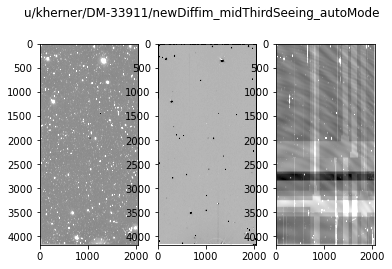

In [7]:
collection_list = [ i.collection for i in apdbs_nonempty ]
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)
    diffim = butler.get(selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{collections.split("/")[-1]}')

In [6]:
def makeplots(run):
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    templName=run.templName
    dbPath = apdb
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    # Good DIA Sources
    fig = plt.figure(figsize=(4,4))
    xlim = (150.45, 149.8)
    ylim = (2.1, 2.5)
    ax = fig.add_subplot(111)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection).split("/")[-1]})')
    
    # Good DIA Sources by visit
    bandList = ['g', 'r']
    colorList = ['C2', 'C1']
    for band, color in zip(bandList, colorList):
        pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
                                    title=band+' band', color=color, size=5)
    
    # How many DIA Sources comprise each DIA Object
    hist = doa.plotDiaObjectHistogram(objTable, goodObj)
    
    # Flag bar chart
    pla.plotFlagHist(srcTable, badFlagList=badFlagList)
    
    # Flux distributions
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='psFlux',
                        title='DIA Sources, HSC-G, Diffim PSF Flux', color1='C2', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='psFlux',
                        title='DIA Sources, HSC-R, Diffim PSF Flux', color1='C1', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='totFlux',
                        title='DIA Sources, HSC-G, Calexp PSF Flux', color1='C2', binmin=-1e3, binmax=2e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='totFlux',
                        title='DIA Sources, HSC-R2, Calexp PSF Flux', color1='C1', binmin=-1e3, binmax=2e3)
    
    # Flux histograms
    pla.source_magnitude_histogram(repo, goodSrc, 'g', 'HSC', collection)
    pla.source_magnitude_histogram(repo, goodSrc, 'r', 'HSC', collection)
    
    # A few cutouts
    for index, source in goodSrc[:4].iterrows():
        dataId = {'detector': int(goodSrc['ccd'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler,
                                                                              dataId,
                                                                              collection,
                                                                              center,
                                                                             diffName='goodSeeing',
                                                                             templName=templName)
        plc.plotCutout(scienceCutout, differenceCutout, templateCutout)

In [7]:
run_list = apdbs_nonempty

### Set 1: Old image differencing

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


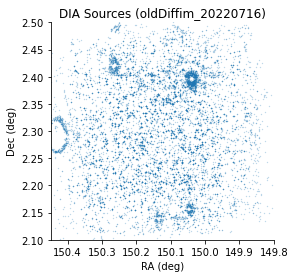

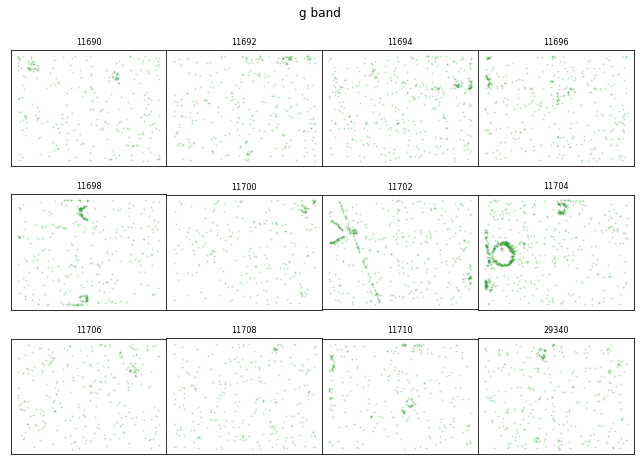

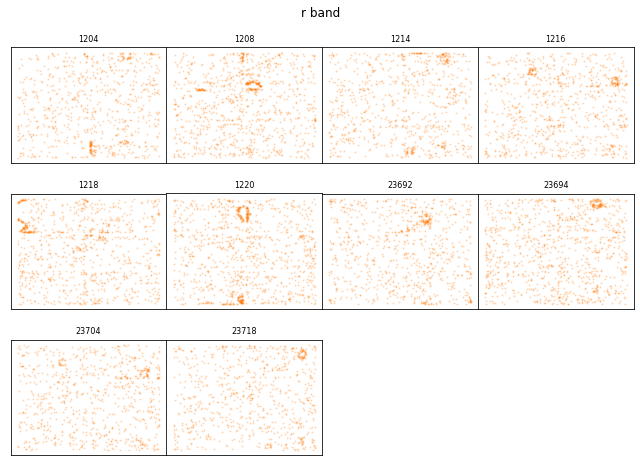

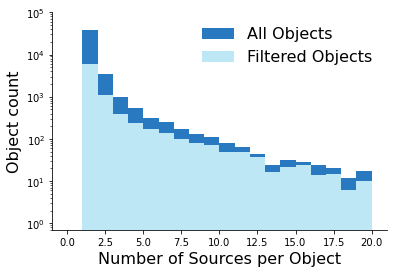

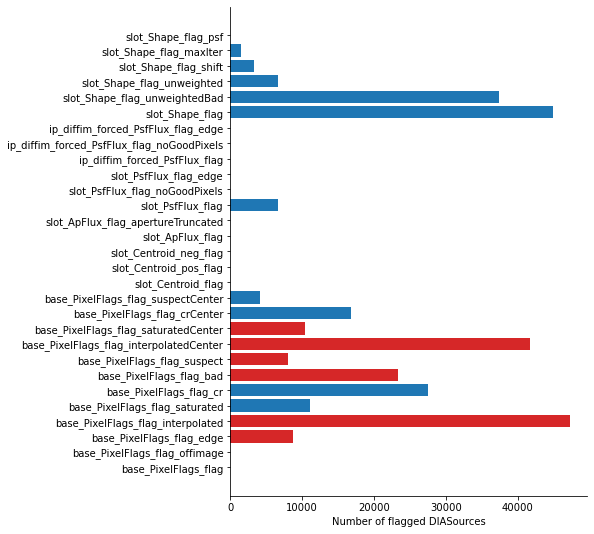

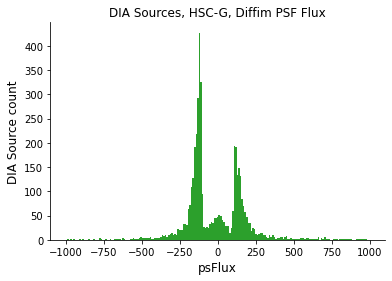

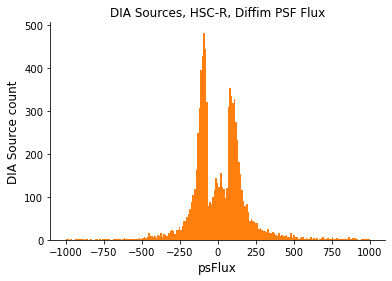

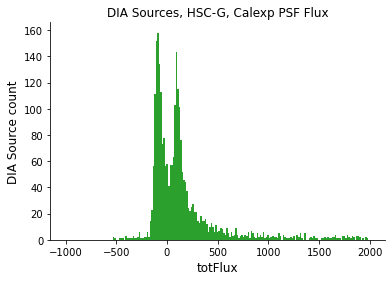

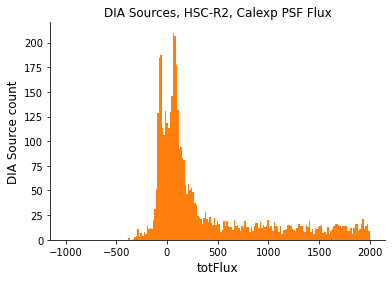

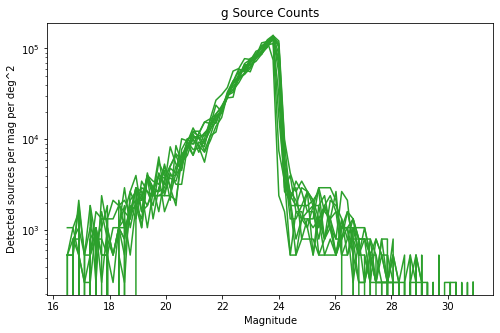

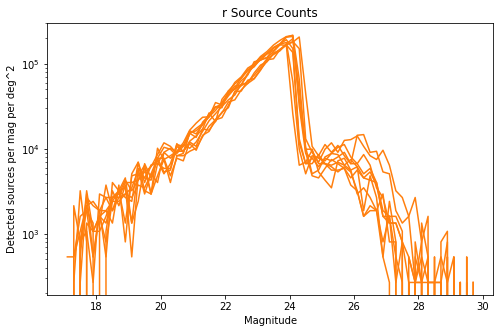

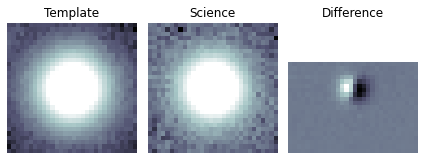

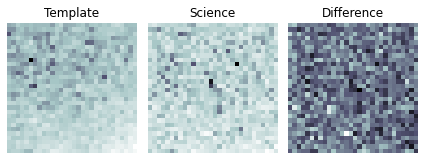

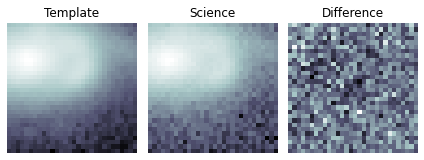

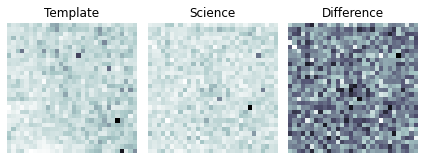

In [35]:
makeplots(old_diffim)

### Set 2: new image differencing with forceCompatibility on

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


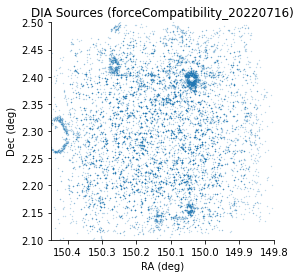

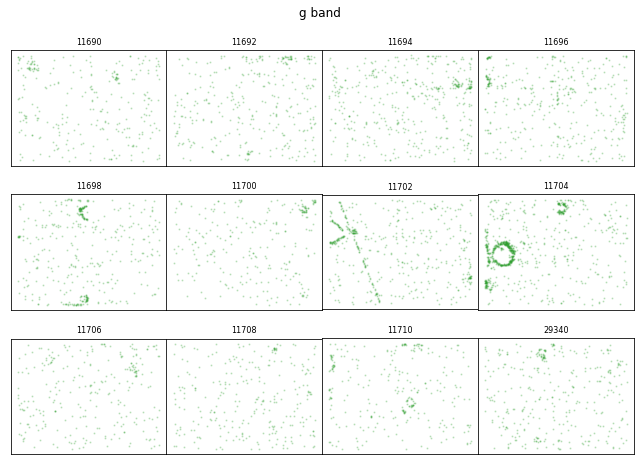

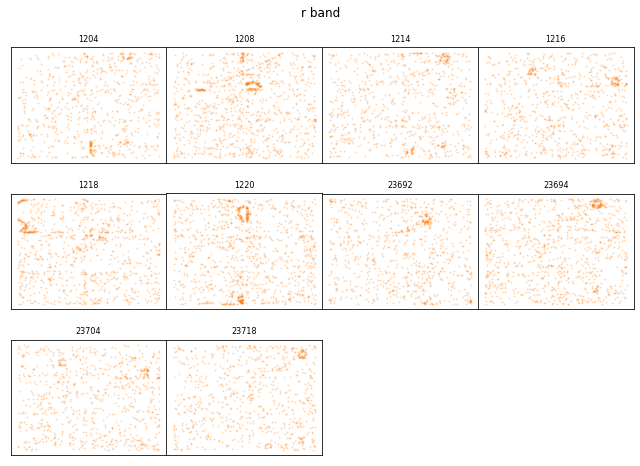

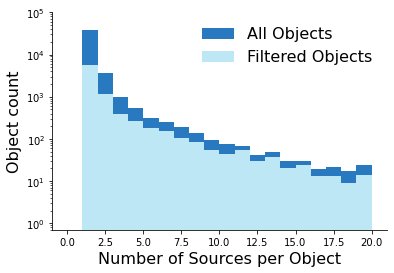

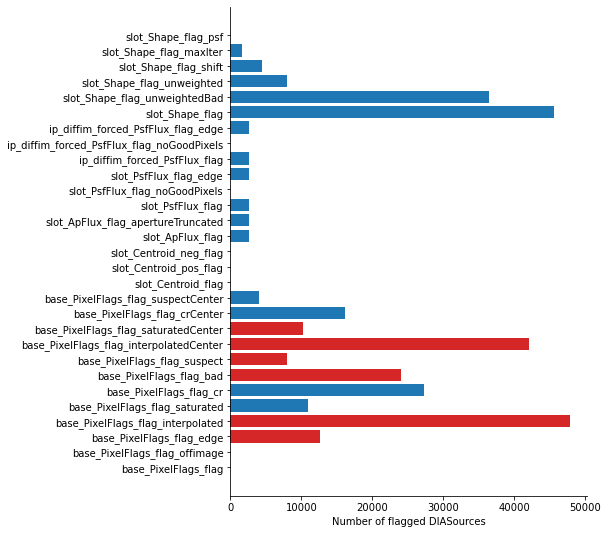

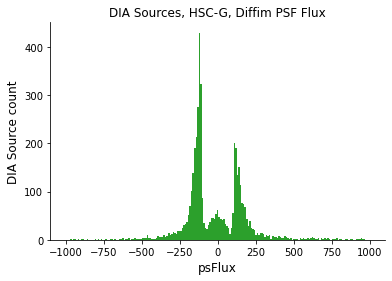

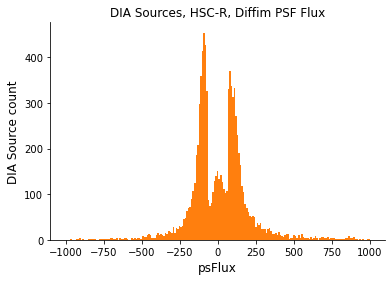

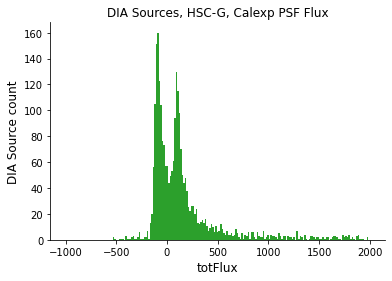

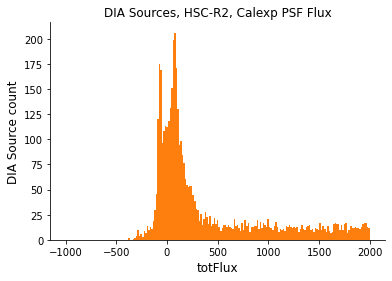

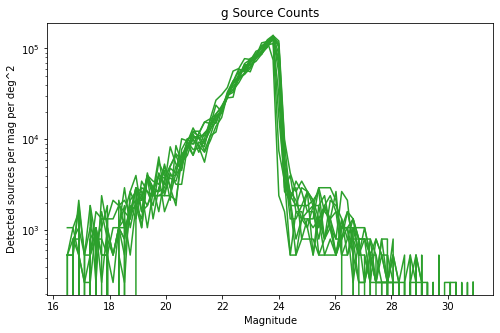

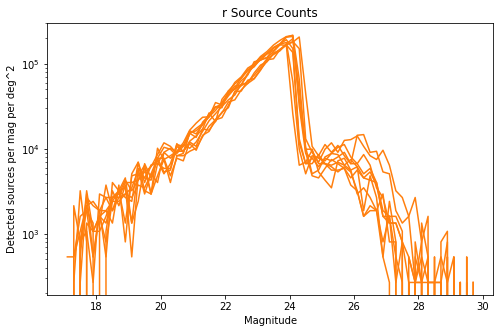

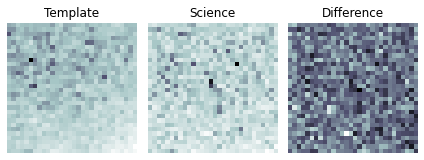

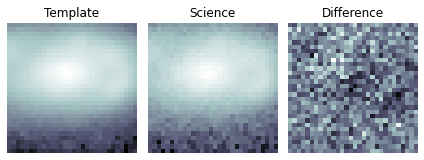

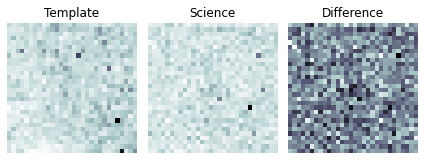

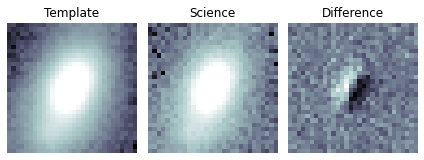

In [44]:
makeplots(new_forceCompat)

### Set 3: new image differencing with best third seeing templates, force compat off, convolve template 

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


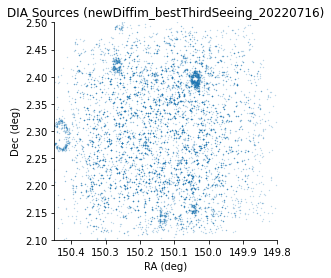

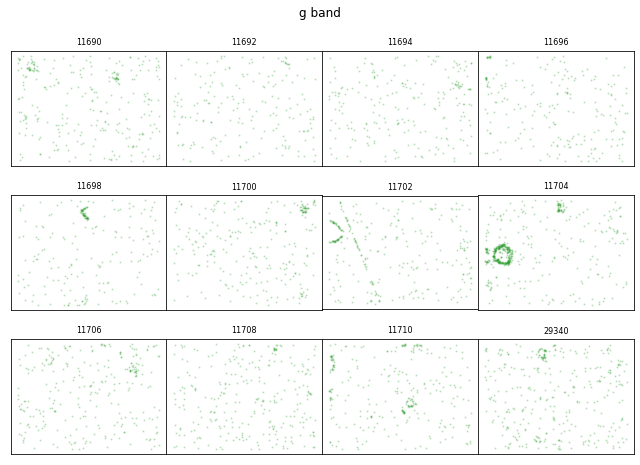

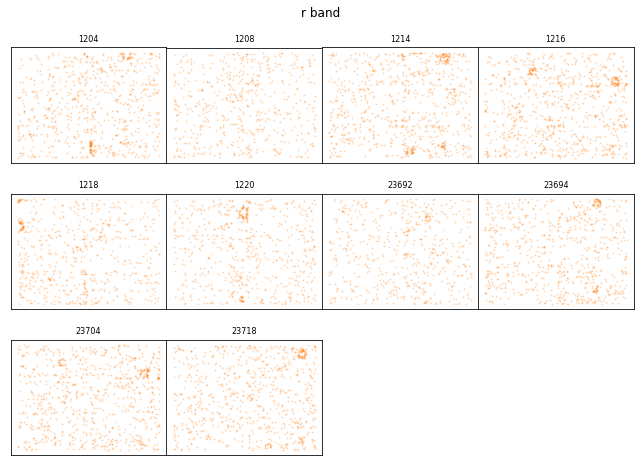

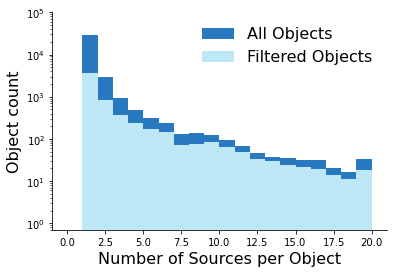

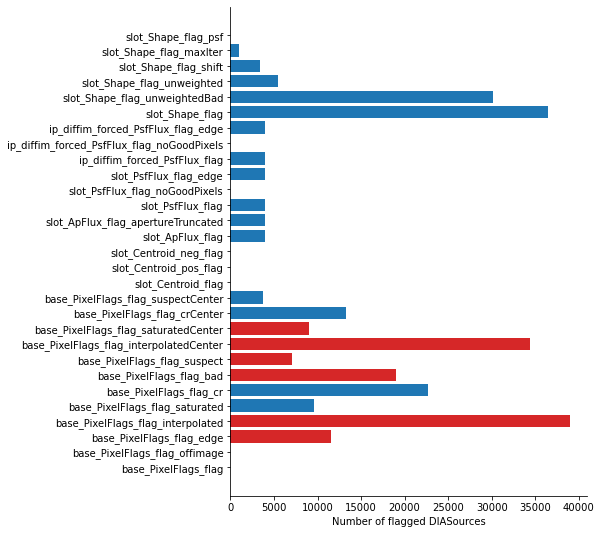

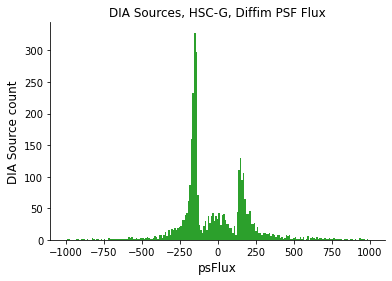

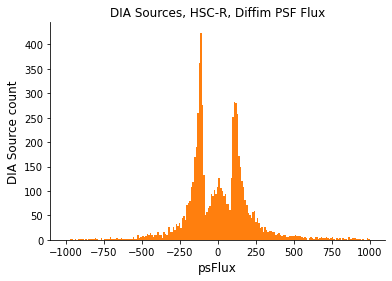

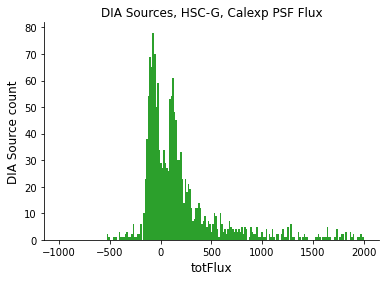

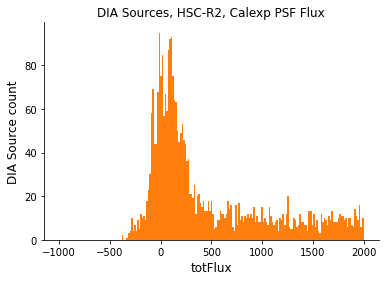

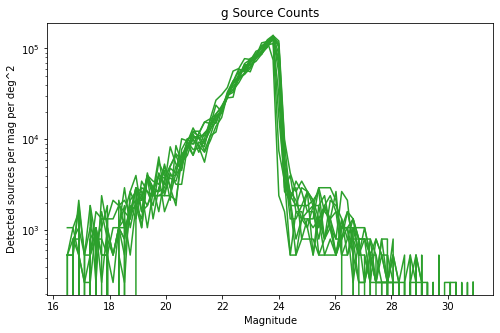

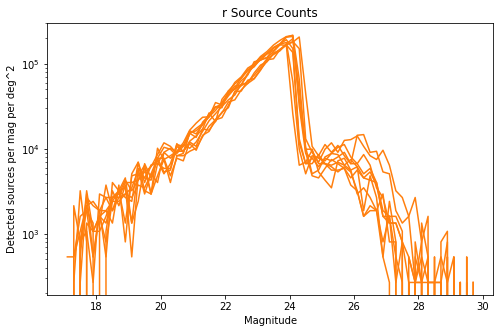

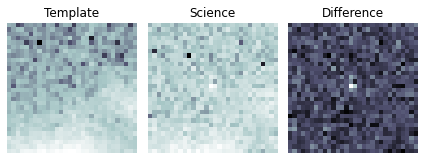

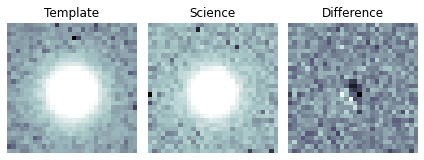

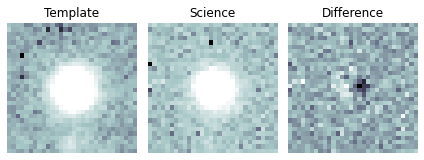

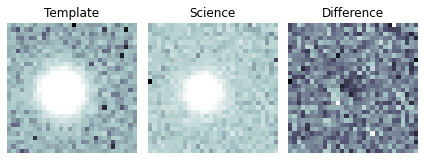

In [45]:
makeplots(new_convolveTemplate)

### Set 4: new image differencing with mid third seeing templates, force compat off, convolve science

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


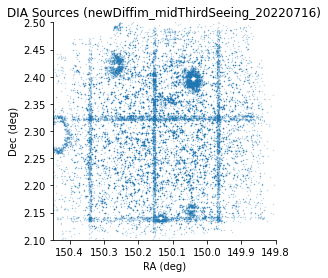

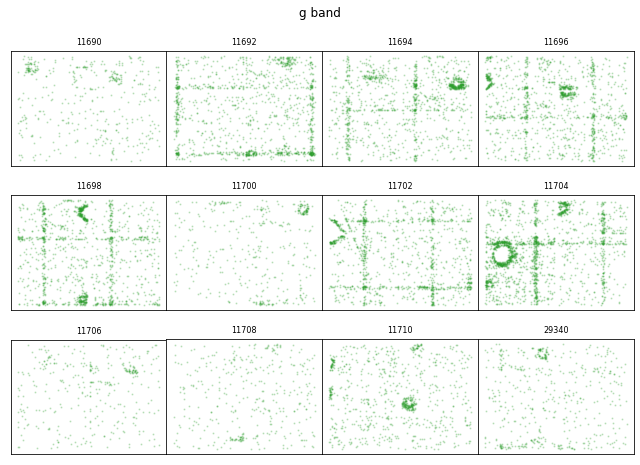

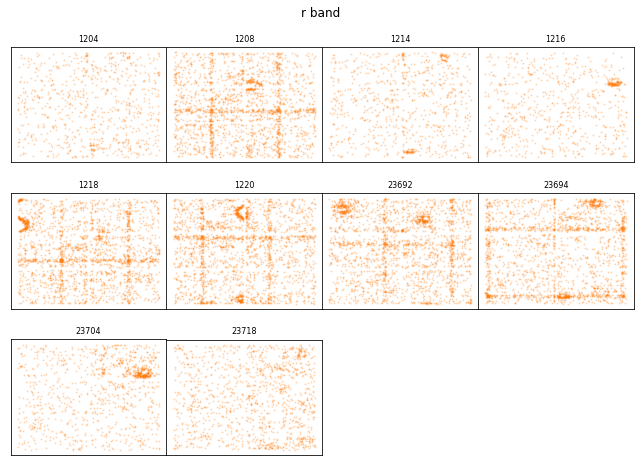

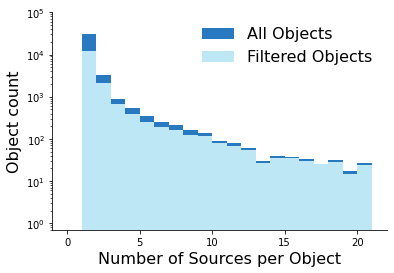

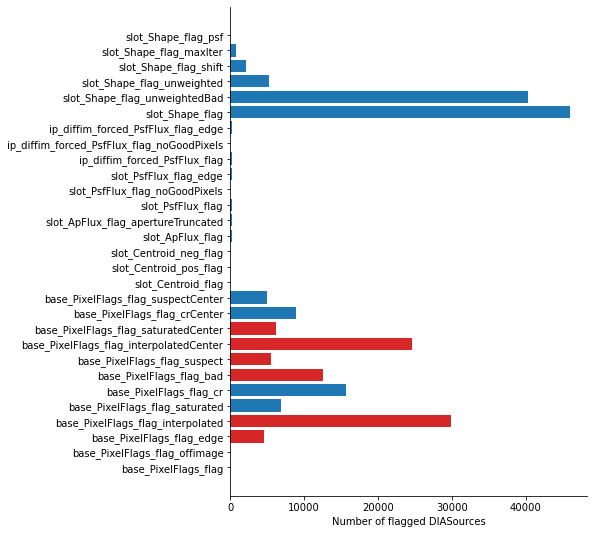

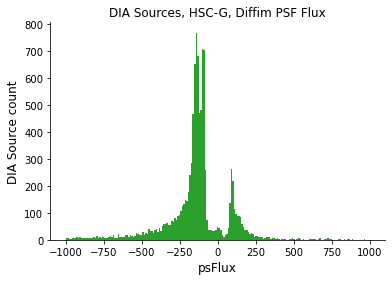

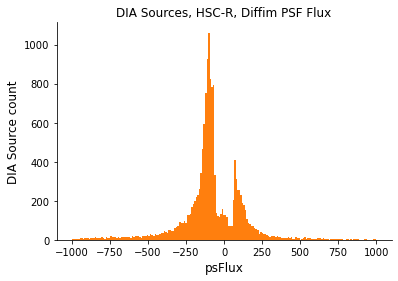

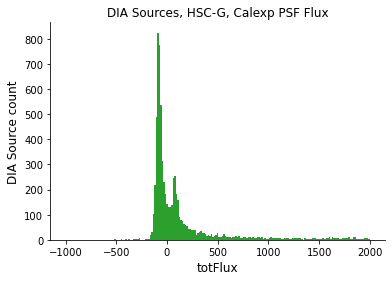

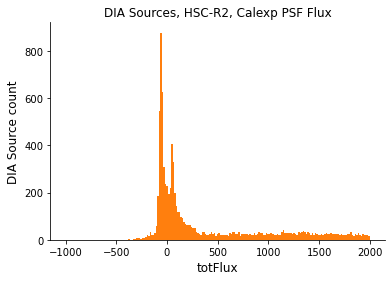

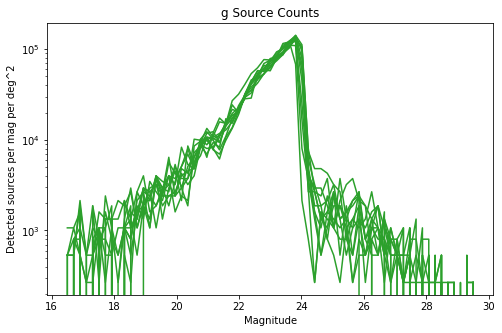

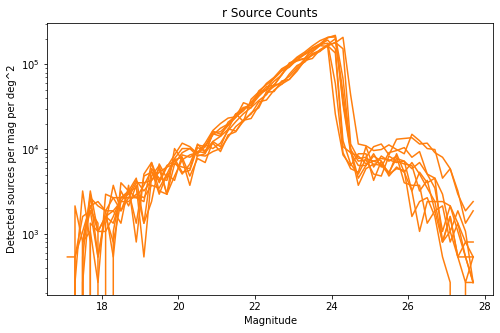

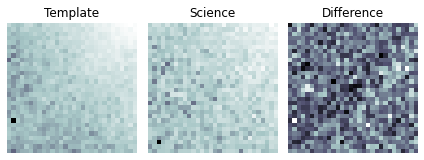

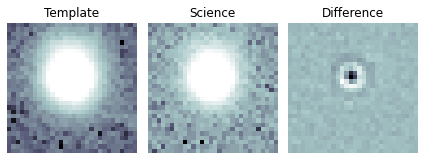

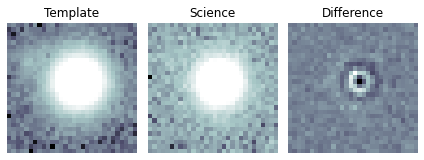

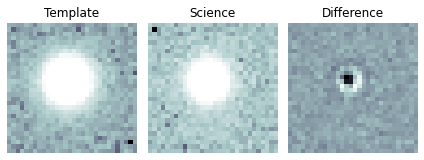

In [46]:
makeplots(new_convolveScience)

### Set 5: new image differencing with best third seeing templates, force compat off, auto mode

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


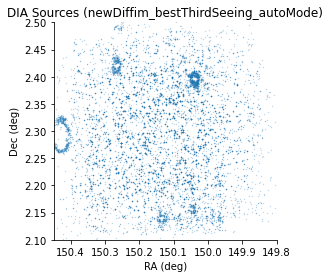

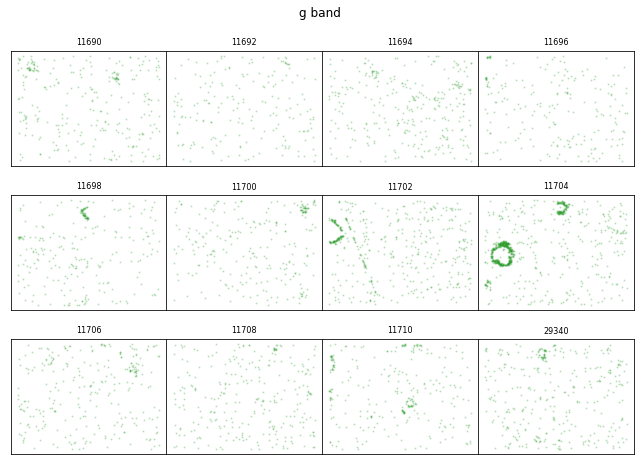

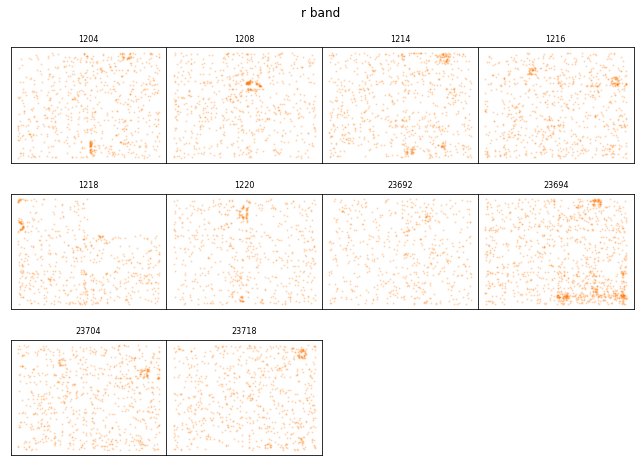

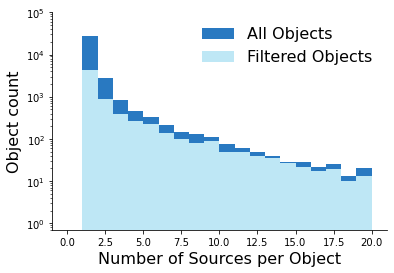

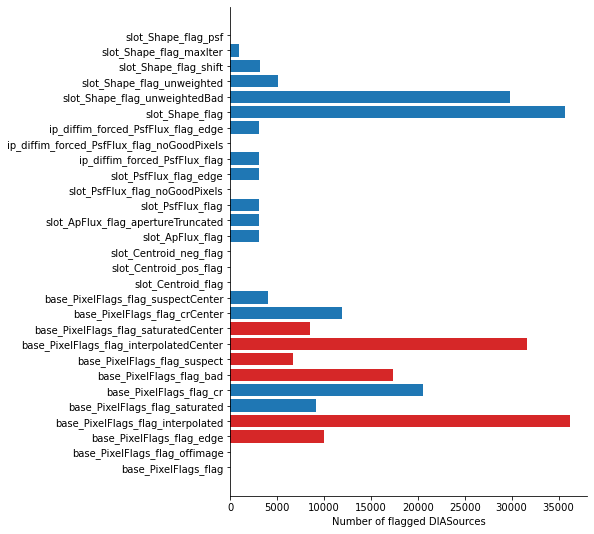

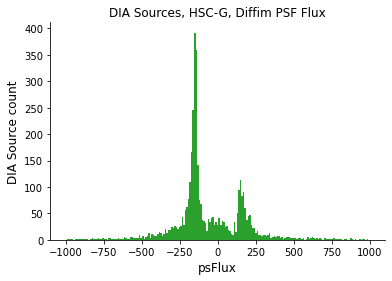

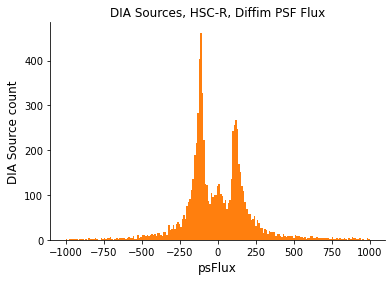

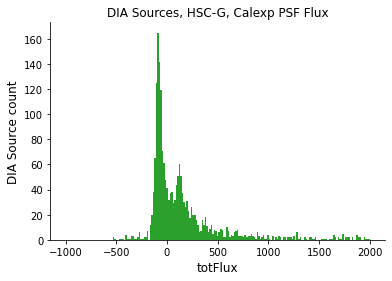

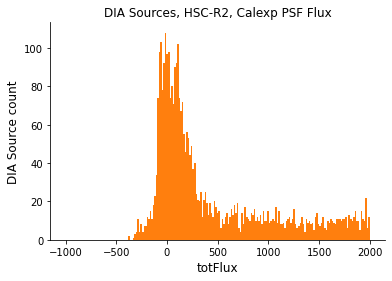

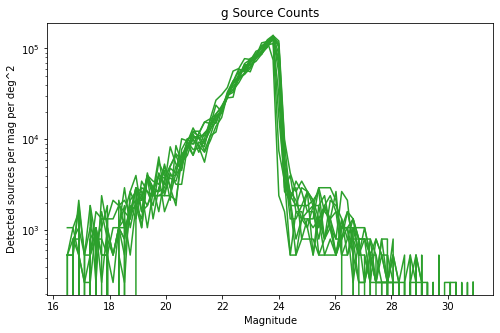

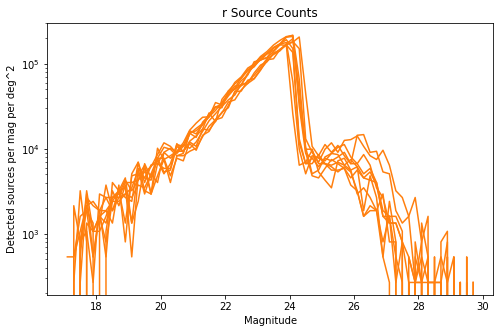

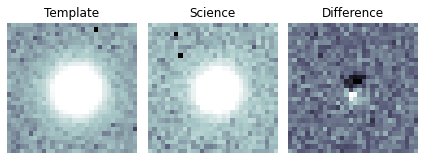

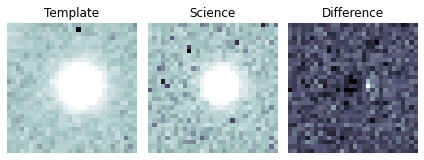

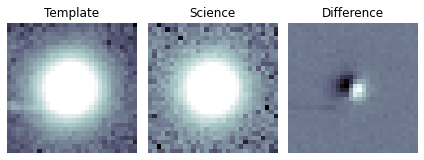

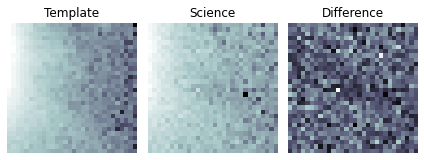

In [29]:
makeplots(new_best_auto)

### Set 6: new image differencing with mid third seeing templates, force compat off, auto mode

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


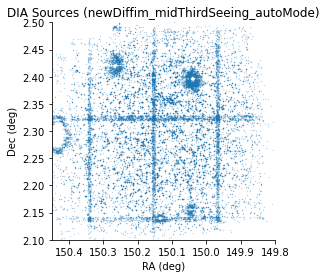

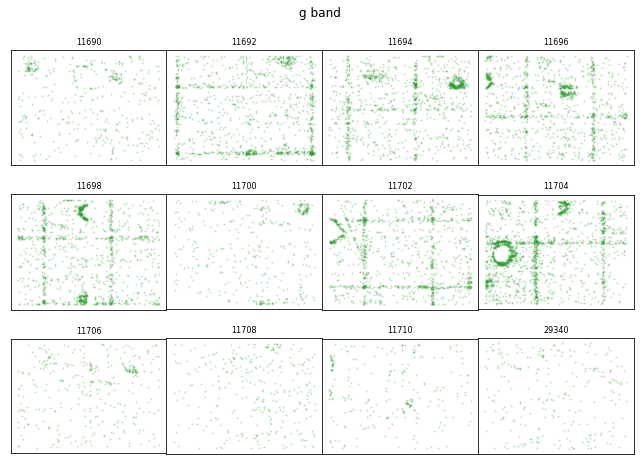

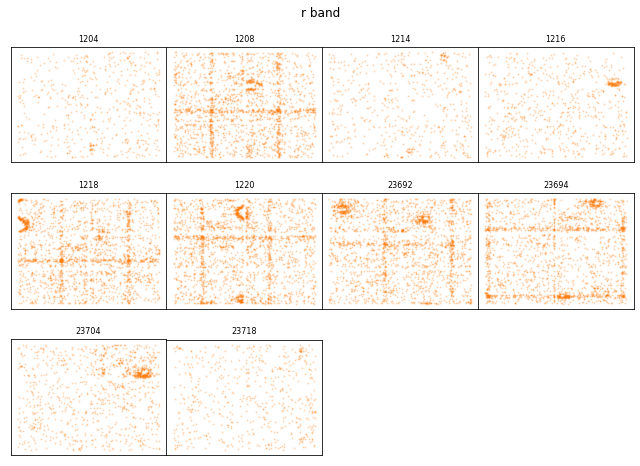

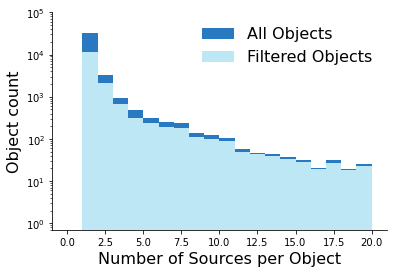

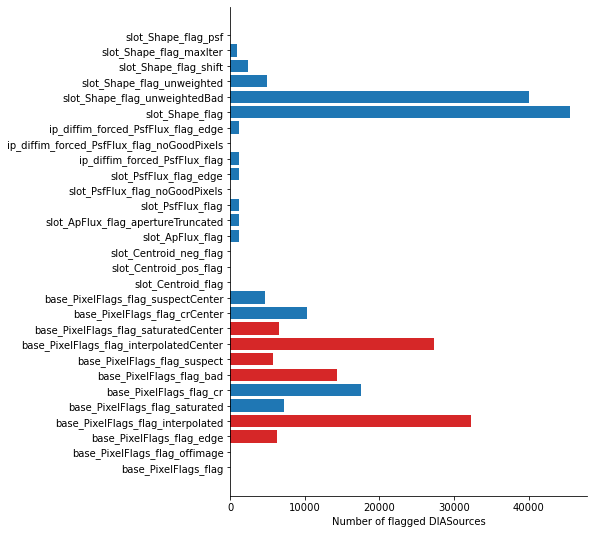

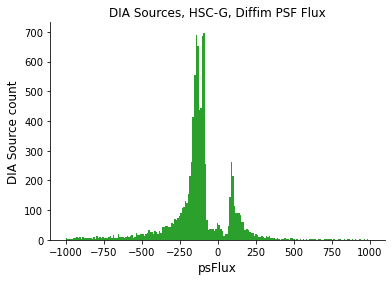

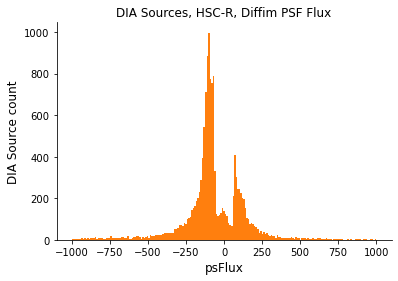

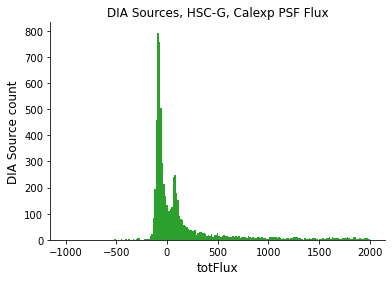

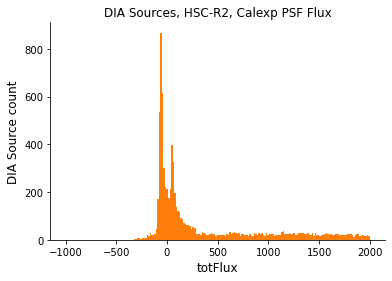

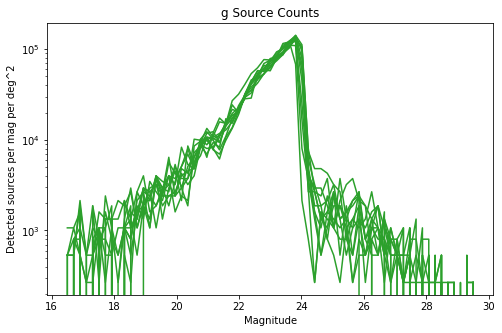

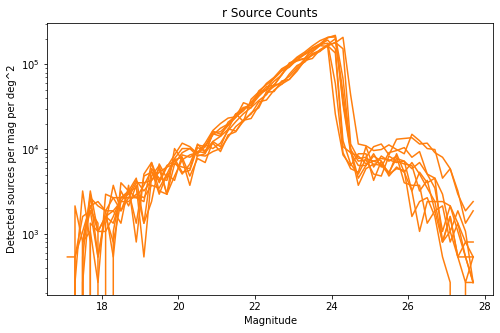

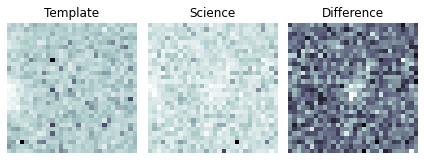

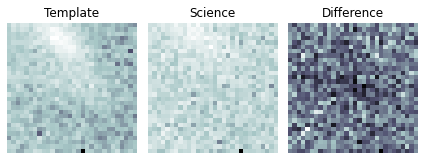

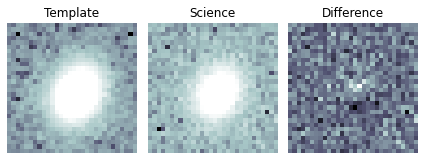

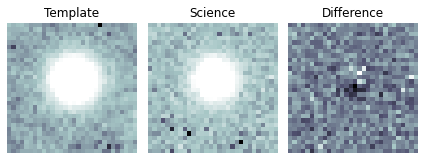

In [30]:
makeplots(new_mid_auto)

In [11]:
def allTables(run):

    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    dbPath = apdb

    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    
    return flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlche

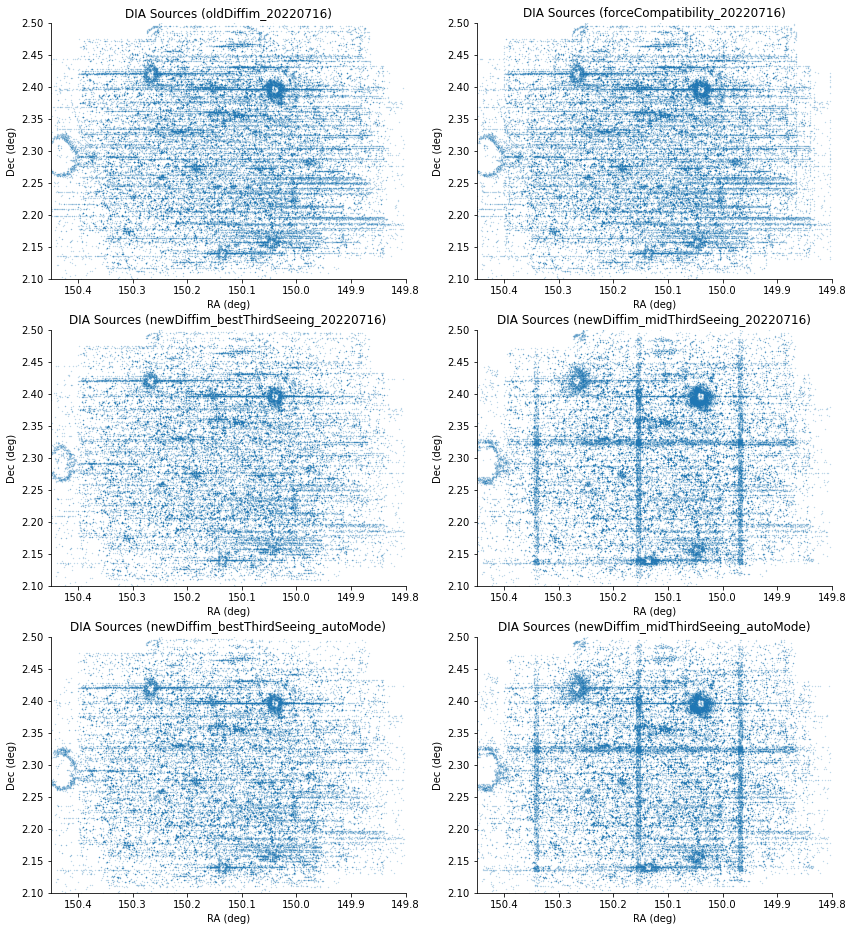

In [34]:
 # Good DIA Sources
fig = plt.figure(figsize=[14.0, 16.0])
gspec = fig.add_gridspec(3, 2)
xlim = (150.45, 149.8)
ylim = (2.1, 2.5)
iplt = 0
fluxType='psFlux'
for collection in run_list:
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
    fluxcut = 1500.0 # value of 1500 determined below.
    BS = srcTable.loc[abs(srcTable[fluxType])>=fluxcut]
    goodBS = goodSrc.loc[abs(goodSrc[fluxType])>=fluxcut]
    ax = fig.add_subplot(gspec[int(iplt/2),iplt%2])
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(srcTable['ra'], srcTable['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection.collection).split("/")[-1]})')
    iplt += 1

In [77]:
def inbounds(ra, decl, RAmin=0, RAmax=360, DECmin=-90, DECmax=90, wrapval=360.):
    """
    Determine whether a given ra, dec pair sits inside a window specified by RAmin, RAmax, DECmin, DECmax.
    Becuase of the RA wraparound, RAmin represents the point from which the RW window starts and proceeds east,
    possibly crossing the wraparound value, until reaching RAmax. 
    Thus you could specify an RAmax value that was less than your RA min value, and it would interpret your
    desired window as the space between RA min and RA max that included the wraparound value.
    
    Example:
    
    RAmin of 10, RA max of 20 would allow 10 < RA < 20. Simple enough.
    RA min of 350, RA max of 10 would allow 350 < RA < 360 AND 0 < RA <10.
    RA min of 10, RA max of 350 would allow all of 10 < RA < 350, or a 340 degree window.
    Be careful which value is the min and which value is the max.
    
    Parameters:
    ----------
    ra: `float`
      RA of object
    decl: `float`
      Declination of object
    RAmin: `float`
      Beginning of RA window.
    RAmax: `float`
      End of RA window. 
    wrapval: `float`
      Value at which RA wraps around. Assumes 360 for degrees but could be changed
      for e.g. radians
    Returns:
    -------
    inbounds: `bool`
      `True` if the input RA and DEC are both within the specified window.
    """
    #Bounds checking
    if DECmin < -90:
        return ValueError('DECmin must be >= -90')
    if DECmax > 90:
        return ValueError('DECmax must be <= 90')
    # deal with wraparound. Have to be careful if the "lower" bound is west of RA=0 and upper bound is east
    passRA = passDEC = False
    if RAmin < RAmax:
        passRA = (ra>=RAmin)&(ra<RAmax) 
    elif RAmin == RAmax:
        passRA = (ra == RAmin)
    else:
        passRA = (ra >= RAmin and ra<(RAmax + wrapval)) or (ra >= (RAmin-wrapval) and ra<RAmax)
    if DECmin == DECmax:
        passDEC = (decl == DECmin)
    else:
        passDEC = (decl<DECmax)&(decl>=DECmin)
    return passRA&passDEC

### Here is the main overlay plotting code. It's now in a function to make it easier to try multiple windows and flux cuts

In [93]:
def BSplots(fluxcut=0, fluxtype = 'psFlux', RAmin=0, RAmax=360,
            DECmin=-90, DECmax=90, useAbsFlux=False):

    fluxType = 'psFlux'
    xlim = (RAmax + 0.025, RAmin - 0.025)
    ylim = (DECmin - 0.025, DECmax + 0.025)
    histfig =  plt.figure(figsize=[14.0, 16.0])
    overlayfig =  plt.figure(figsize=[14.0, 14.0])
    histgspec = histfig.add_gridspec(3, 2)
    autofig = plt.figure(figsize=[14.0, 14.0])
    #collection_list = [default_best, middle_convolvesci, preconvolve_best, preconvolve_middle]
    collection_list = apdbs_nonempty
    iplt = 0
    olax = overlayfig.add_subplot()
    autoax = autofig.add_subplot()
    plt.setp(olax, xlim=xlim, ylim=ylim)
    olax.set_xlabel('RA (deg)')
    olax.set_ylabel('Dec (deg)')
    olax.set_title(f'Bright DIA Sources by collection')
    plt.setp(autoax, xlim=xlim, ylim=ylim)
    autoax.set_xlabel('RA (deg)')
    autoax.set_ylabel('Dec (deg)')
    autoax.set_title(f'Bright DIA Sources by collection')

    color = [ 'b', 'g', 'r', 'k', 'y', 'c']
    #color = [ 'b', 'g', 'r', 'k']
    mrkr = [ 'o', 'v', 's', '*', '^', 'p' ]
    automrkr = []
    autocolor = []
    autolbl = []

    #mrkr = [ 'o', 'v', 's', '*']
    for collection in collection_list: 
        flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, objTable, srcTable = allTables(collection)
        if useAbsFlux:
            BS = srcTable.loc[(abs(srcTable[fluxType])>=fluxcut)&(inbounds(goodSrc['ra'],
                                                                   goodSrc['decl'],
                                                                   RAmin=RAmin,
                                                                   RAmax=RAmax,
                                                                   DECmin=DECmin,
                                                                   DECmax=DECmax)==True)]
            goodBS = goodSrc.loc[(abs(goodSrc[fluxType])>=fluxcut)&(inbounds(goodSrc['ra'],goodSrc['decl'],
                                                                RAmin=RAmin,
                                                                RAmax=RAmax,
                                                                DECmin=DECmin,
                                                                DECmax=DECmax)==True)]            
        else:
            BS = srcTable.loc[(srcTable[fluxType]>=fluxcut)&(inbounds(goodSrc['ra'],
                                                                   goodSrc['decl'],
                                                                   RAmin=RAmin,
                                                                   RAmax=RAmax,
                                                                   DECmin=DECmin,
                                                                   DECmax=DECmax)==True)]
            goodBS = goodSrc.loc[(goodSrc[fluxType]>=fluxcut)&(inbounds(goodSrc['ra'],goodSrc['decl'],
                                                                RAmin=RAmin,
                                                                RAmax=RAmax,
                                                                DECmin=DECmin,
                                                                DECmax=DECmax)==True)]
        #goodBS = goodSrc.loc[(goodSrc[fluxType]>=fluxcut)&(goodSrc['ra']>=RAmin)&(goodSrc['ra']<RAmax)\
        #                             &(goodSrc['decl']>=DECmin)&(srcTable['decl']<DECmax)]
        print("{} : {}".format(str(collection.collection),len(goodBS)))
        histax = histfig.add_subplot(histgspec[int(iplt/2),iplt%2])
        plt.setp(histax, xlim=xlim, ylim=ylim)
        histax.scatter(goodBS['ra'], goodBS['decl'], c=color[iplt], s=15.0,marker=mrkr[iplt], alpha=0.4, label=collection.collection)
        histax.set_xlabel('RA (deg)')
        histax.set_ylabel('Dec (deg)')
        histax.set_title(f'Bright DIA Sources ({str(collection.collection).split("/")[-1]})')
        olax.scatter(goodBS['ra'], goodBS['decl'], color=color[iplt], s=15.0,marker=mrkr[iplt], alpha=0.4, label=collection.collection)
    # Separate plot for just the auto mode runs
        if 'autoMode' in collection.collection:
            autoax.scatter(goodBS['ra'], goodBS['decl'], c=color[iplt], s=15.0,
                   marker=mrkr[iplt], alpha=0.4, label=collection.collection)
            autocolor.append(color[iplt])
            automrkr.append(mrkr[iplt])
            autolbl.append((collection.collection).split("/")[-1])
        iplt += 1
    # Good DIA Sources by visit
    # bandList = ['g', 'r']
    # colorList = ['C2', 'C1']
    # for band, color in zip(bandList, colorList):
    #    pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
    mylegend = olax.legend(labels=[(coll.collection).split("/")[-1] for coll in collection_list],
                           loc='best',labelcolor=color)
    olax.add_artist(mylegend)
    myleg2 = autoax.legend(labels=autolbl, loc='best',labelcolor=autocolor)
    autoax.add_artist(myleg2)
    plt.show()

### Let's try plotting only an area that's well inside a patch boundary so we don't get too many edge effects.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/oldDiffim_20220716 : 19


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/forceCompatibility_20220716 : 15


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_20220716 : 14


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_20220716 : 24


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_autoMode : 16


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_autoMode : 20


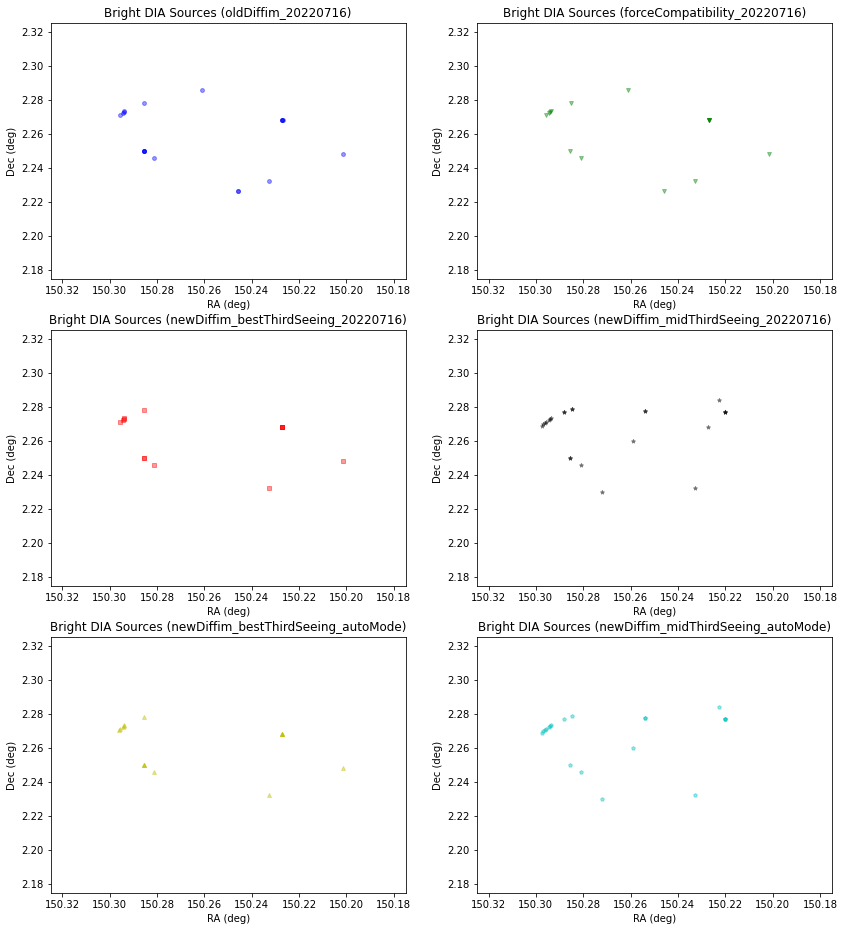

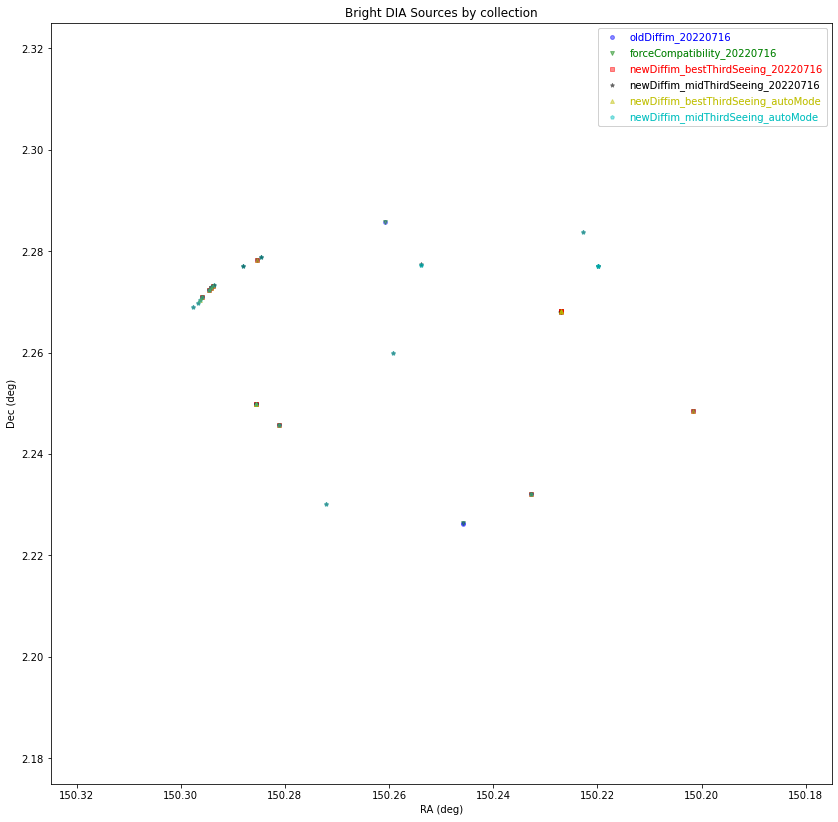

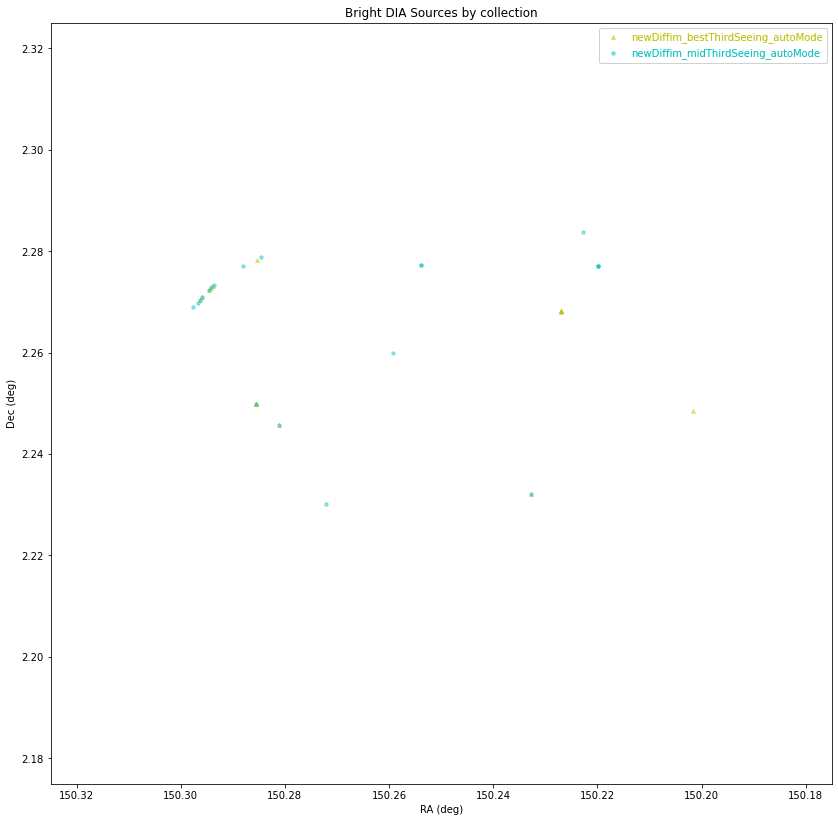

In [91]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=150.2, RAmax=150.3, DECmin=2.2, DECmax=2.3)

### Now run the same, but cut on the absolute value of the flux instead, to see how well we match negative bright sources.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/oldDiffim_20220716 : 23


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/forceCompatibility_20220716 : 19


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_20220716 : 17


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_20220716 : 114


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_autoMode : 26


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_autoMode : 90


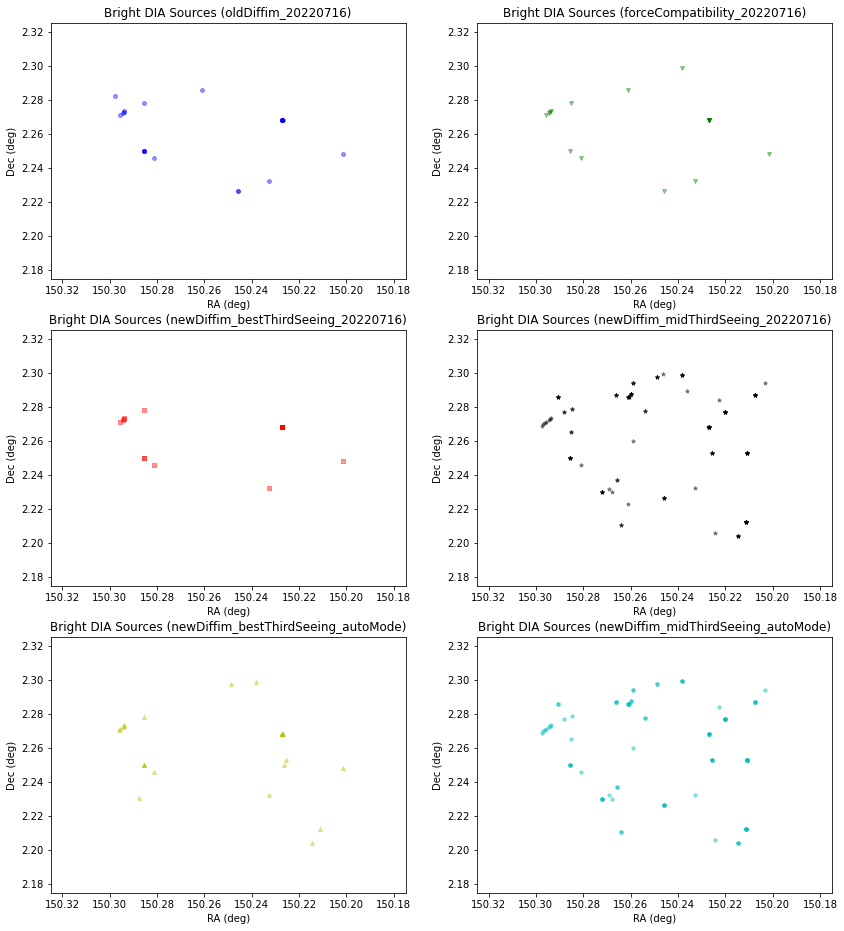

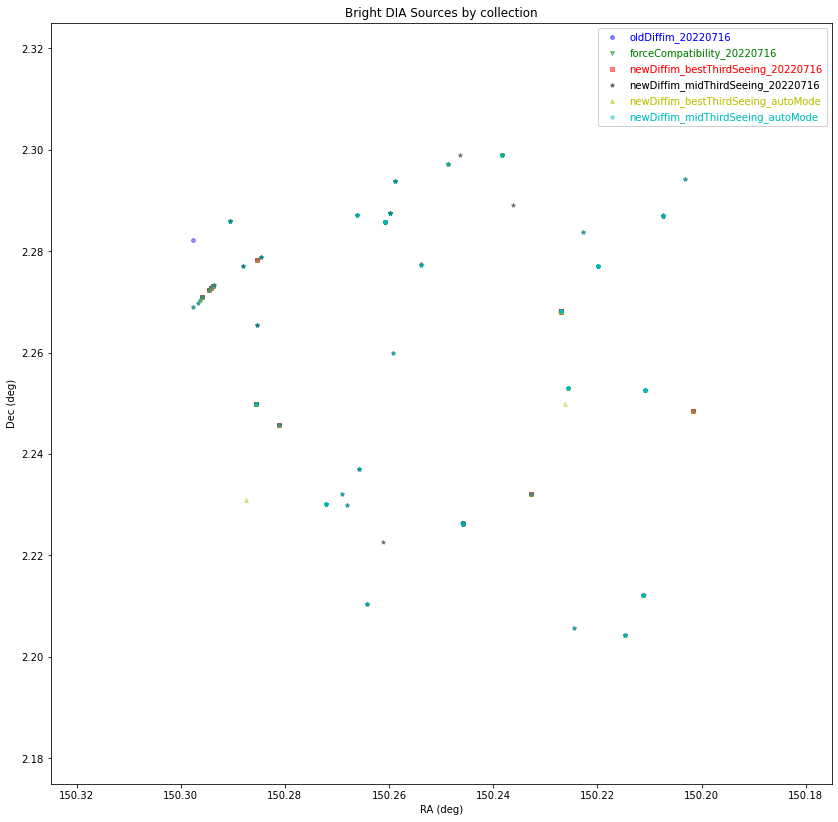

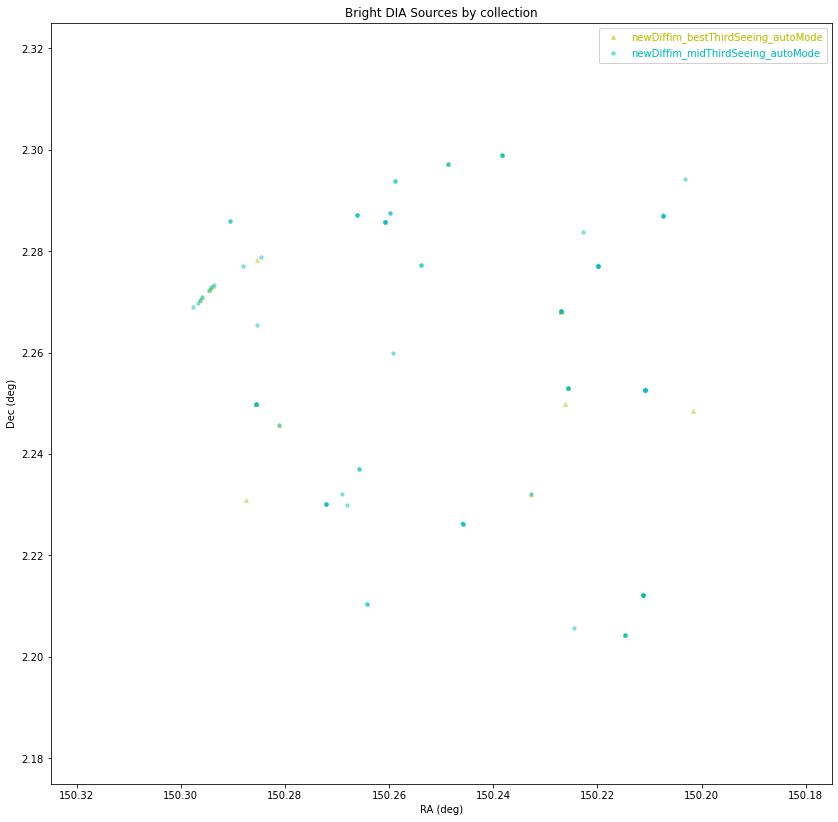

In [92]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=150.2, RAmax=150.3, DECmin=2.2,
        DECmax=2.3,useAbsFlux=True)

Hmm, still an excess of negative sources in the convolve science case.

### Let's do another one with a slightly different window.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/oldDiffim_20220716 : 3


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/forceCompatibility_20220716 : 5


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_20220716 : 5


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_20220716 : 9


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_bestThirdSeeing_autoMode : 5


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


u/kherner/DM-33911/newDiffim_midThirdSeeing_autoMode : 8


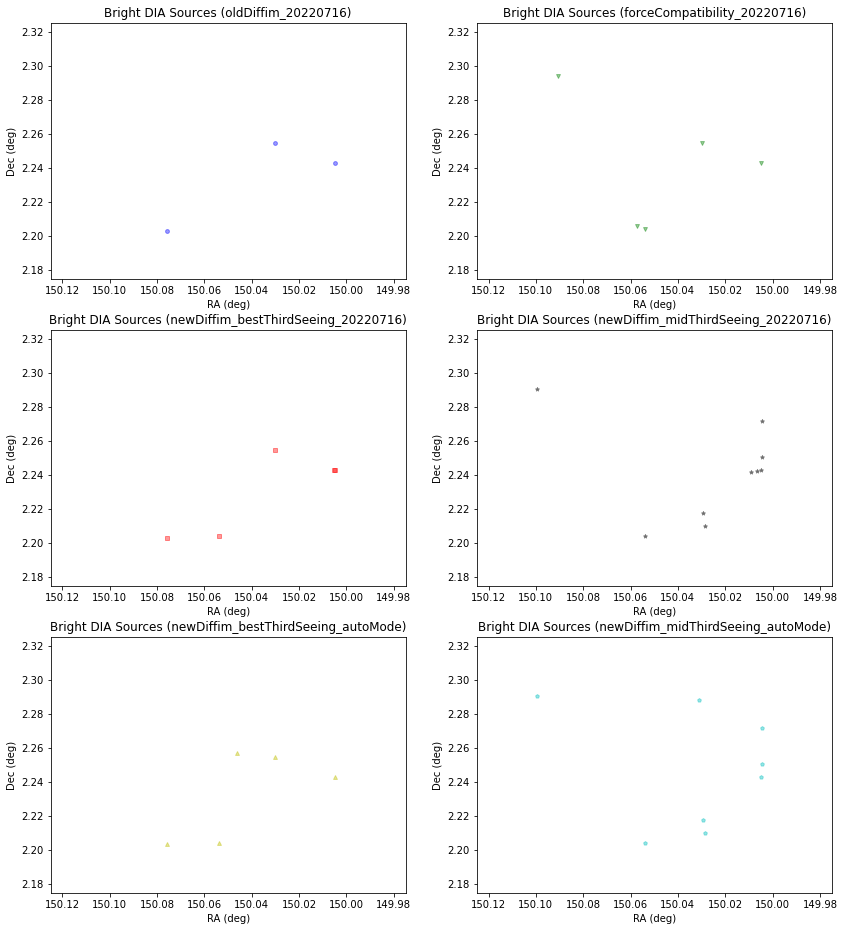

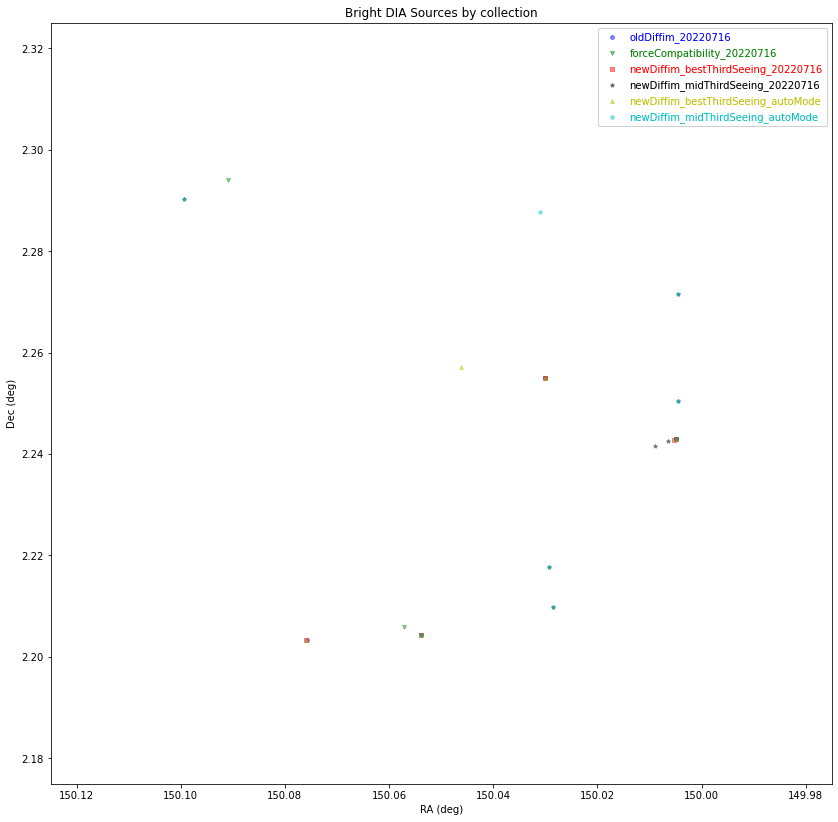

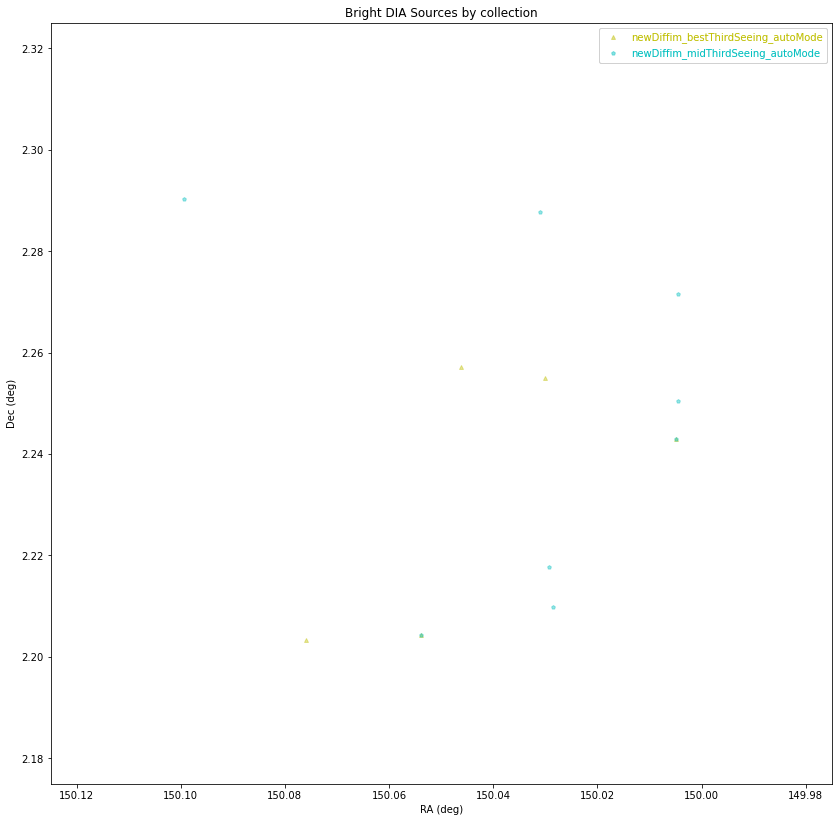

In [89]:
BSplots(fluxcut=1000,fluxtype='psFlux', RAmin=150.0, RAmax=150.1, DECmin=2.2, DECmax=2.3)

In [88]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj, \
objTable, srcTable = allTables(new_forceCompat)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(0.0, 40.0)

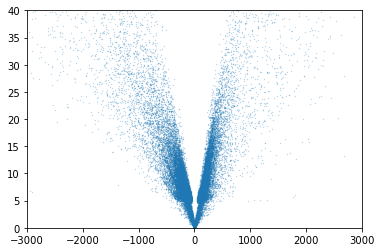

In [18]:
fluxType='psFlux' 
xlim = (-3000, 3000)
ylim = (0, 40)
plt.scatter(srcTable[fluxType],
            abs(srcTable[fluxType]/srcTable[fluxType+'Err']),
            c='C0', s=0.1, marker='o', alpha=0.4)
plt.xlim(xlim)
plt.ylim(ylim)

In [20]:
goodSrcCounts = {}
for run in run_list:
    flagTable, srcTableFlags, flagFilter, goodSrc,\
    goodObj, objTable, srcTable = allTables(run)
    goodSrcCounts[run.collection] = goodSrc['visit'].value_counts()

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlche

In [21]:
merged = pd.merge(goodSrcCounts[old_diffim.collection],
                   goodSrcCounts[new_convolveTemplate.collection],
                  left_index=True, right_index=True,
                  suffixes=["_old", "_convTemp"])

In [22]:
automerged = pd.merge(goodSrcCounts[new_best_auto.collection],
                   goodSrcCounts[new_mid_auto.collection],
                  left_index=True, right_index=True,
                  suffixes=["_bestThird", "_midThird"])

Print the good source counts per visit in old diffim

In [23]:
for cvid, count in sorted(goodSrcCounts[old_diffim.collection].iteritems()):
    print(cvid,count)

1204 795
1208 1039
1214 842
1216 884
1218 975
1220 1107
11690 286
11692 310
11694 413
11696 364
11698 392
11700 254
11702 482
11704 848
11706 278
11708 269
11710 292
23692 866
23694 1048
23704 821
23718 790
29340 344


In [24]:
merged = pd.merge(merged, goodSrcCounts[new_convolveScience.collection],
                  left_index=True, right_index=True,
                  suffixes=["_convSci"])

Compare good source counts per visit for old diffim, new convolve template, and new convolve science (right)

In [25]:
merged

visit_old  visit_convTemp  visit
1220        1107             645   2347
23694       1048             748   2109
1208        1039             559   2053
1218         975             637   2218
1216         884             865    745
23692        866             562   2242
11704        848             544   2015
1214         842             824    826
23704        821             827   1089
1204         795             770    773
23718        790             794   1226
11702        482             298   1231
11694        413             223   1214
11698        392             222   1333
11696        364             215   1260
29340        344             349    508
11692        310             192   1238
11710        292             289    832
11690        286             281    420
11706        278             279    351
11708        269             283    369
11700        254             258    408

u/kherner/DM-33911/oldDiffim_20220716
u/kherner/DM-33911/newDiffim_bestThirdSeeing_20220716
u/kherner/DM-33911/newDiffim_midThirdSeeing_20220716


<Figure size 720x720 with 0 Axes>

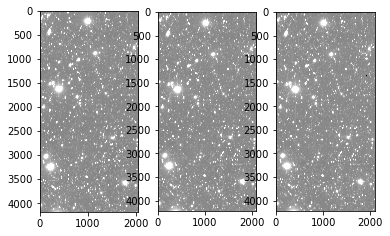

In [26]:
visit = 1220
detector = 50


def templPlot(ns, visit, detector, myax, templNorm=None):
    
    collection = ns.collection
    print(collection)
    templName = 'goodSeeing' + ns.templName
    template = butler.get(templName, instrument='HSC',
                        visit=visit, detector=detector, collections=collection)
    if templNorm is None:
        templNorm = ImageNormalize(template.image.array,
                                   interval=ZScaleInterval(), stretch=SqrtStretch())
        templVarNorm = ImageNormalize(template.variance.array,
                                      interval=ZScaleInterval(), stretch=SqrtStretch())
    myax.imshow(template.image.array, cmap='gray', norm=templNorm)
    return templNorm

fig = plt.figure(figsize=(10,10))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

basenorm = templPlot(old_diffim, visit, detector, ax1)
basenorm = templPlot(new_convolveTemplate, visit, detector, ax2, basenorm)
basenorm = templPlot(new_convolveScience, visit, detector, ax3, basenorm)


In [14]:
dataId = {"instrument": "HSC", "patch": 40, "band": "g", "skymap": "hsc_rings_v1", "tract": 9813}
dataIdv = {"instrument": "HSC","band": "g", "skymap": "hsc_rings_v1", "tract": 9813, "visit": visit, "detector": detector}

cai = butler.get('goodSeeingDiff_templateExp', dataId=dataIdv, collections=new_convolveTemplate.collection)


In [12]:
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))

def getFWHM(collections, visit, band):
    dataId = {"band": band, "skymap": "hsc_rings_v1", "tract":9813,
              "visit":visit, "detector": 50}
    collname = 'calexp'
    #try:
    psf = butler.get(collname, instrument='HSC',
                          dataId=dataId, collections=collections).getPsf()
    fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm
    #except:
    #    print("Unable to calculate psf for {}, visit {}".format(collname, visit))
    #    fwhm = 0
    return fwhm

Take a look at the seeing for each input. Middle third seeing templates to start.

In [62]:
cai = butler.get('goodSeeingCoadd.coaddInputs', dataId=dataId, collections=new_convolveScience.collection)
for visit in cai.visits.asAstropy()['id']:
    print("{} : {}".format(visit, getFWHM(new_convolveScience.collection,visit, 'g')))

/tmp/ipykernel_2683/1482150819.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11690 : 4.692484743155409
11700 : 4.592872822420454
11706 : 4.588495834428637
11708 : 4.79448530410553
11710 : 5.260561429660502
29340 : 5.018484148754482


In [16]:
scienceg = [11690, 11692, 11694, 11696, 11698, 11700, 11702, 11704, 
            11706, 11708, 11710, 11712, 29340]
sciencer = [1204, 1208, 1210, 1214, 1216, 1218, 1220,
            23692, 23694, 23704, 23718]

In [17]:
# Dump the seeing for the g-band science images
for visit in scienceg:
    print("{} : {}".format(visit, getFWHM(new_convolveScience.collection,visit, 'g')))

/tmp/ipykernel_2727/1482150819.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11690 : 4.692484743155409
11692 : 4.445218466132228
11694 : 4.344575315046857
11696 : 4.489010323478474
11698 : 4.430481675830029
11700 : 4.592872822420454
11702 : 4.323198651179878
11704 : 4.209887591551477
11706 : 4.588495834428637
11708 : 4.79448530410553
11710 : 5.260561429660502
11712 : 5.50698834728379
29340 : 5.018484148754482


In [67]:
# Dump the seeing for the r-band science images
for visit in sciencer:
    print("{} : {}".format(visit, getFWHM(new_convolveScience.collection,visit, 'r')))

/tmp/ipykernel_2683/1482150819.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


1204 : 3.3085060824717147
1208 : 2.8821459654970476
1210 : 4.676886531997026
1214 : 3.298058984031409
1216 : 3.041868880645674
1218 : 2.8574501225871636
1220 : 2.9480226118670467
23692 : 2.896411827190317
23694 : 2.69424430124386
23704 : 2.9793535608422976
23718 : 3.342669676575166


In [64]:
cai = butler.get('goodSeeingCoadd.coaddInputs', dataId=dataId, collections=new_convolveScience.collection)
for visit in scienceg:
    print("{} : {}".format(visit, getFWHM(new_convolveTemplate.collection,visit, 'g')))

/tmp/ipykernel_5787/424442732.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11690 : 4.673849786560486
11692 : 4.4571611057382
11694 : 4.378855944622513
11696 : 4.471431340140053
11698 : 4.3969629690458545
11700 : 4.522716019676368
11702 : 4.304550344240914
11704 : 4.190397187695535
11706 : 4.572009675527479
11708 : 4.806860177758731
11710 : 5.26697904643485
11712 : 5.462935402077756
29324 : 5.414139334060002
29326 : 5.675105167352842
29336 : 5.5184571874903865
29340 : 4.947009840088687
29350 : 7.0608582450029


In [68]:
cai = butler.get('goodSeeingCoadd.coaddInputs', dataId=dataId, collections=new_convolveTemplate.collection)
for visit in cai.visits.asAstropy()['id']:
    print("{} : {}".format(visit, getFWHM(new_convolveTemplate.collection,visit, 'r')))

/tmp/ipykernel_2683/1482150819.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11692 : 4.445218466132228
11694 : 4.344575315046857
11696 : 4.489010323478474
11698 : 4.430481675830029
11702 : 4.323198651179878
11704 : 4.209887591551477


In [19]:
# dump seeing of the input coadds
cai = butler.get('goodSeeingCoadd.coaddInputs', dataId=dataId, collections=new_convolveScience.collection)
for visit in cai.visits.asAstropy()['id']:
    print("{} : {}".format(visit, getFWHM(new_convolveScience.collection,visit, 'r')))

/tmp/ipykernel_2727/1482150819.py:10: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


11690 : 4.692484743155409
11700 : 4.592872822420454
11706 : 4.588495834428637
11708 : 4.79448530410553
11710 : 5.260561429660502
29340 : 5.018484148754482


In [18]:
tempmid = [11700, 11706, 11690, 11708, 29340, 11710, 23704, 1216, 1204,
           1214, 23718, 30494, 30496, 30498, 30488, 30492, 30504, 19698,
           30486, 1238, 30482, 1246, 17900, 17950, 17952, 17948, 17934,
           17932, 1186, 1192, 1188, 1190, 11732, 22648, 11724, 11728,
           11722, 11726, 22608, 11740, 11738, 11734, 11720, 1880, 1876,
           870, 1872, 1874, 348]
tempbest = [11704, 11702, 11694, 11698, 11692, 11696, 23694, 1208, 1218,
            23692, 1220, 19682, 19684, 19680, 19662, 30502, 19658, 30490,
            30500, 19696, 19694, 19660, 17928, 17906, 17908, 17904, 17926,
            17902, 17930, 17946, 17962, 17900, 22602, 22604, 22644, 22632,
            22628, 22642, 22630, 22626, 22664, 11730, 22662, 11736, 22646,
            22606, 11718, 22660, 22658]

In [ ]:
# Debugging: print the seeing of various templates.
for visit in tempmid:
    try:
        print("{} {}: {}".format(visit, 'g', getFWHM('u/kherner/DM-33911/templates_midThirdSeeing_20220623',
                                          visit, 'g')))
    except:
        try:
            print("{} {}: {}".format(visit, 'r', getFWHM('u/kherner/DM-33911/templates_midThirdSeeing_20220623',
                                          visit, 'r')))
        except:
            print('Unable to fetch visit '+ str(visit))